# Setup

In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# import attr

In [78]:
import torch
torch.__version__

'1.0.0.dev20181027'

In [79]:
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import models

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [81]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [82]:
matplotlib.__version__

'3.0.1'

In [83]:
def plot_image(img):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img);

# Load Data

In [121]:
from segmentation.dataset import AMDataset

In [84]:
from pathlib import Path
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import img_to_tensor
from albumentations import (
    PadIfNeeded
)

In [89]:
base_path = Path('data/raw')
tile_size = 512

In [91]:
image_dirs = [image_dir for image_dir in base_path.iterdir()]
image_dirs

[PosixPath('data/raw/n1_SELECTED'),
 PosixPath('data/raw/c2_SELECTED'),
 PosixPath('data/raw/h3_SELECTED')]

In [99]:
img = cv2.imread(str('data/raw/n1_SELECTED/image.png'))
nrows, ncols = img.shape[:2]
nrows, ncols

(3698, 3747)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_dirs, valid_dirs = \
    train_test_split(image_dirs, test_size=0.3, random_state=42)

In [19]:
train_dirs, valid_dirs

([PosixPath('data/raw/c2_SELECTED'), PosixPath('data/raw/h3_SELECTED')],
 [PosixPath('data/raw/n1_SELECTED')])

In [122]:
train_ds = AMDataset(train_dirs, tile_size=tile_size, transform=None)
valid_ds = AMDataset(valid_dirs, tile_size=tile_size, transform=None)

data/raw/c2_SELECTED
data/raw/h3_SELECTED
data/raw/n1_SELECTED


In [123]:
len(train_ds), len(valid_ds)

(128, 64)

In [125]:
train_ds.source_image_n_slices

{'data/raw/c2_SELECTED': 64, 'data/raw/h3_SELECTED': 64}

In [126]:
train_ds.source_image_padding

{'data/raw/c2_SELECTED': [200, 180], 'data/raw/h3_SELECTED': [331, 290]}

# Define Models

In [38]:
# unet11 = UNet11()

# Train Models

In [342]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import time
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Normalize,
    Compose,
    PadIfNeeded,
    RandomCrop,
    CenterCrop
)

In [343]:
from segmentation.model import UNet11

In [344]:
class LossBinary(object):
    """ Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """
    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = torch.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [345]:
def jaccard(y_pred, y_true):
    y_true = torch.squeeze(y_true, dim=1)
    y_pred = torch.squeeze(y_pred, dim=1)
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1)
    union = y_true.sum(dim=-2).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1)
    return ((intersection + epsilon) / (union - intersection + epsilon))

In [346]:
def train_transform(p=1):
    return Compose([
#         PadIfNeeded(min_height=args.train_crop_height, min_width=args.train_crop_width, p=1),
#         RandomCrop(height=args.train_crop_height, width=args.train_crop_width, p=1),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        Normalize(p=1)
    ], p=p)

def valid_transform(p=1):
    return Compose([
#         PadIfNeeded(min_height=args.val_crop_height, min_width=args.val_crop_width, p=1),
#         CenterCrop(height=args.val_crop_height, width=args.val_crop_width, p=1),
        Normalize(p=1)
    ], p=p)

In [347]:
train_ds = AMDataset(train_dirs, tile_size=tile_size, transform=train_transform())
valid_ds = AMDataset(valid_dirs, tile_size=tile_size, transform=valid_transform())

data/raw/c2_SELECTED
data/raw/h3_SELECTED
data/raw/n1_SELECTED


In [348]:
batch_size = 4
train_dl = DataLoader(
    dataset=train_ds,
    shuffle=True,
    num_workers=4,
    batch_size=batch_size,
    pin_memory=torch.cuda.is_available()
)
valid_dl = DataLoader(
    dataset=valid_ds,
    shuffle=False,
    num_workers=4,
    batch_size=batch_size,
    pin_memory=torch.cuda.is_available()
)

In [349]:
len(train_dl), len(valid_dl)

(32, 16)

In [350]:
lr = 1e-3
n_epochs = 5

In [351]:
model = UNet11()
model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=0.5)

In [352]:
# plot_img(torch.sigmoid(outputs)[0,0,:,:].detach())

In [353]:
# plot_img(outputs.detach().numpy().squeeze())

In [354]:
start = time.time()
for epoch in range(0, n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    print('-' * 10)
    model.train()
    
    running_loss, running_metric = 0.0, 0.0
    for i, (inputs, targets) in enumerate(train_dl):
        print('.', end='')
        inputs = inputs.to('cuda')
        
        with torch.no_grad():
            targets = targets.to('cuda')
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_metric += jaccard((outputs > 0).float(), targets).sum().item()
    
    running_loss /= len(train_dl.dataset)
    running_metric /= len(train_dl.dataset)
    print(f'\nTrain loss: {running_loss:.5f}, train metric: {running_metric:.5f}')
    
    with torch.no_grad():
        model.eval()
        losses, metrics = [], []
        for inputs, targets in valid_dl:
            print('.', end='')
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item() * inputs.size(0))
            metric = jaccard((outputs > 0).float(), targets).sum().item()
            metrics.append(metric)

        valid_loss = sum(losses) / len(valid_dl.dataset)
        valid_metric = sum(metrics) / len(valid_dl.dataset)

        print(f'\nValid loss: {valid_loss:.5f}, valid metric: {valid_metric:.5f}')
    
    elapsed = int(time.time() - start)
    print(f'{elapsed // 60} min {elapsed % 60} sec')

Epoch 1/5
----------
................................
Train loss: 0.67777, train metric: 0.59924
................
Valid loss: 0.15320, valid metric: 0.78104
1 min 9 sec
Epoch 2/5
----------
................................
Train loss: 0.14530, train metric: 0.77474
................
Valid loss: 0.19091, valid metric: 0.71004
2 min 18 sec
Epoch 3/5
----------
................................
Train loss: 0.13726, train metric: 0.77024
................
Valid loss: 0.17346, valid metric: 0.74545
3 min 27 sec
Epoch 4/5
----------
................................
Train loss: 0.13192, train metric: 0.78934
................
Valid loss: 0.16747, valid metric: 0.75270
4 min 37 sec
Epoch 5/5
----------
................................
Train loss: 0.13008, train metric: 0.77479
................
Valid loss: 0.17190, valid metric: 0.74536
5 min 46 sec


In [355]:
torch.save(model.state_dict(), open('unet.pth', 'wb'))

---

# Test Images

In [153]:
model = UNet11(pretrained=False)
state = torch.load(open('unet.pth', 'rb'), map_location=device)
model.load_state_dict(state)
model = model.to(device)

In [ ]:
test_ds = 

In [146]:
it = iter(valid_dl)
for _ in range(5):
    inputs, targets = next(it)
inputs.shape, targets.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 1, 512, 512]))

In [147]:
outputs = model(inputs.to('cuda'))
outputs.shape

torch.Size([2, 1, 512, 512])

In [148]:
targets_pred = torch.sigmoid(outputs)

In [149]:
def convert_to_image(tensor):
    tensor = tensor[0]
    return tensor.detach().cpu().numpy()

In [150]:
def plot_images(images, titles):
    n = min(len(images), 3)
    fig, axes = plt.subplots(1, n, figsize=(16, 8))
    for i in range(n):
        axes[i].imshow(images[i]);
        axes[i].set_title(titles[i])

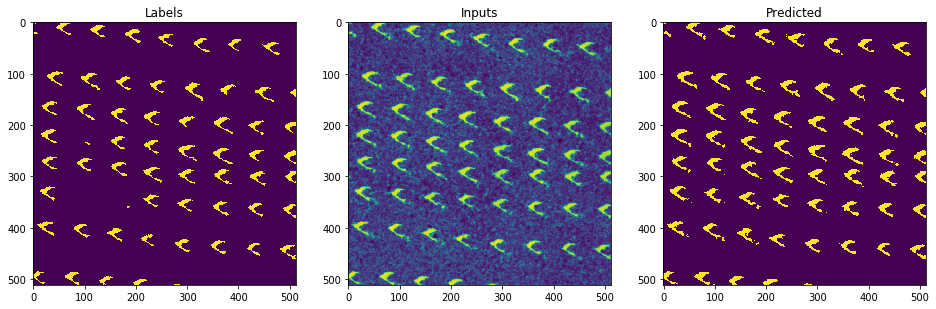

In [151]:
i = 1
plot_images([
    convert_to_image(targets[i]),
    convert_to_image(inputs[i]),
#     convert_to_image(outputs[0])
    convert_to_image(targets_pred[i] > 0.3),
#     convert_to_image(outputs[0] > 0),
], titles=['Labels', 'Inputs', 'Predicted'])

In [62]:
# plot_img(convert_to_image(targets_pred[0]))

In [37]:
def predict_mask(dl, model, threshold=0.3):
    pred_outputs = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in dl:
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs) > threshold
            pred_outputs.append(outputs)
    pred_outputs = torch.squeeze(torch.cat(pred_outputs))
    pred_outputs = pred_outputs.detach().cpu().numpy()
    return pred_outputs

# Inference

In [358]:
from segmentation.inference import SegmentationModel

In [359]:
segm_model = SegmentationModel('unet.pth', tile_size=512)

2019-01-23 08:58:33,848 - am-segm - INFO - Loading model...
2019-01-23 08:58:33,848 - am-segm - INFO - Loading model...


In [360]:
# pred_mask = segm_model.predict_mask('data/raw/n1_SELECTED/source.png')
pred_mask = segm_model.predict_mask('data/raw/AM_cropped_Rho.png')

2019-01-23 08:58:40,905 - am-segm - INFO - Predicting mask for data/raw/AM_cropped_Rho.png...
2019-01-23 08:58:40,905 - am-segm - INFO - Predicting mask for data/raw/AM_cropped_Rho.png...
2019-01-23 08:58:54,084 - am-segm - INFO - Done
2019-01-23 08:58:54,084 - am-segm - INFO - Done


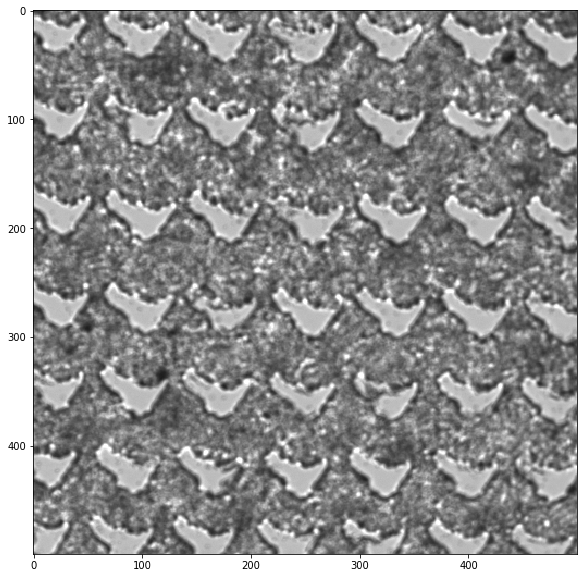

In [362]:
image = cv2.imread('data/raw/AM_cropped_Rho.png')
plot_image(image[1500:2000,1500:2000])

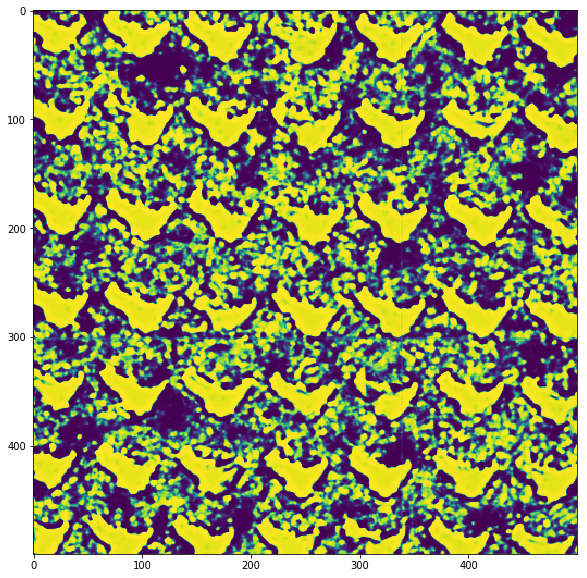

In [364]:
plot_image(pred_mask[1500:2000,1500:2000])

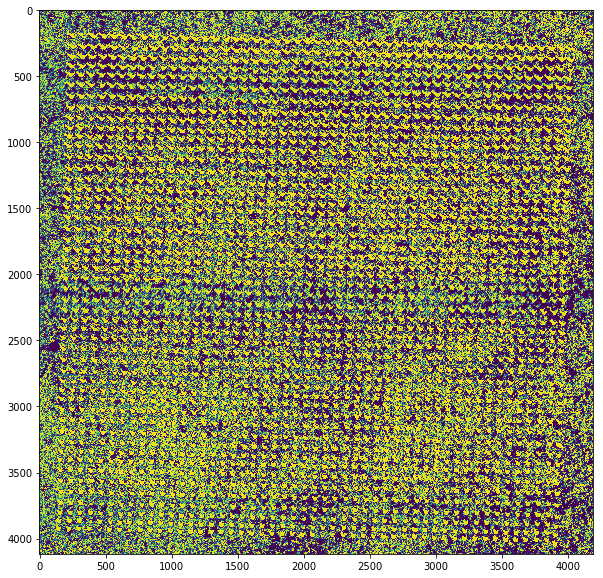

In [365]:
plot_image(pred_mask)

# Other